# Writing Rasters with GDAL

Last lecture we read rasters via our own function. But suppose we want more than just a count of the values in the raster. What if we want to create a new raster and open it in, for instance, QGIS? Here we will talk about how to do this.

We are going to use two data files from the Earthstat dataset. Eartstat is a wonderful source of spatial information relevant to applied economics.

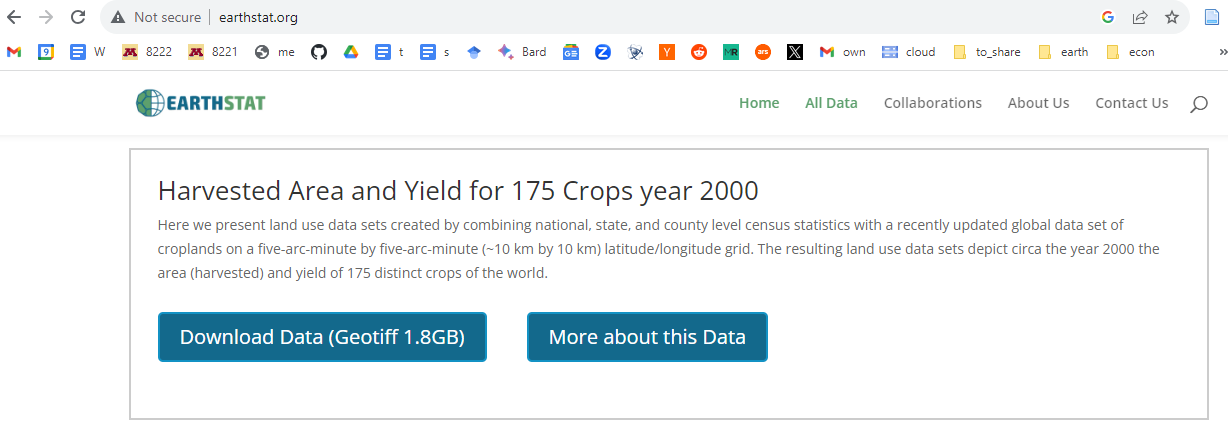

I have already put the files listed below in our googlde drive, but the Earthstat site is here http://www.earthstat.org/ if you want to get your own.

I want you to calculate the production per grid-cell of Maize, globally, at "high"-resolution.

The two files you need are in your class data directory (obtained from google drive) named as follows.

```         
maize_HarvestedAreaHectares.tif
maize_YieldPerHectare.tif
```

Let's start by defining our paths to the data.

In [21]:
# Import our required libraries
import os
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt


# Here again is the relative path to our data directory
data_directory = '../../../../data' 

# Here are the two new filenames, which you should have downloaded
# from google drive into your local data directory
harvested_area_filename = 'maize_HarvestedAreaHectares.tif'
yield_filename = 'maize_YieldPerHectare.tif'

# Create the paths (by joining with your base data directory)
harvested_area_file_path = os.path.join(data_directory, harvested_area_filename)
yield_file_path = os.path.join(data_directory, yield_filename)

# Check that they both exist
print(os.path.exists(harvested_area_file_path))
print(os.path.exists(yield_file_path))

True
True


### Define again our function for opening rasters

I've added a little detail that helps with debugging.

In [22]:
def load_array(input_raster_path):
    """Load a raster into a numpy array"""
    if not os.path.exists(input_raster_path):
        print('The file does not exist')
        return None
    
    raster = gdal.Open(input_raster_path)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array 

### Use our function to load both of the raster paths

In [23]:
harvested_area = load_array(harvested_area_file_path)
yield_per_hectare = load_array(yield_file_path)

Total maize production globally is 593478850.0 tons


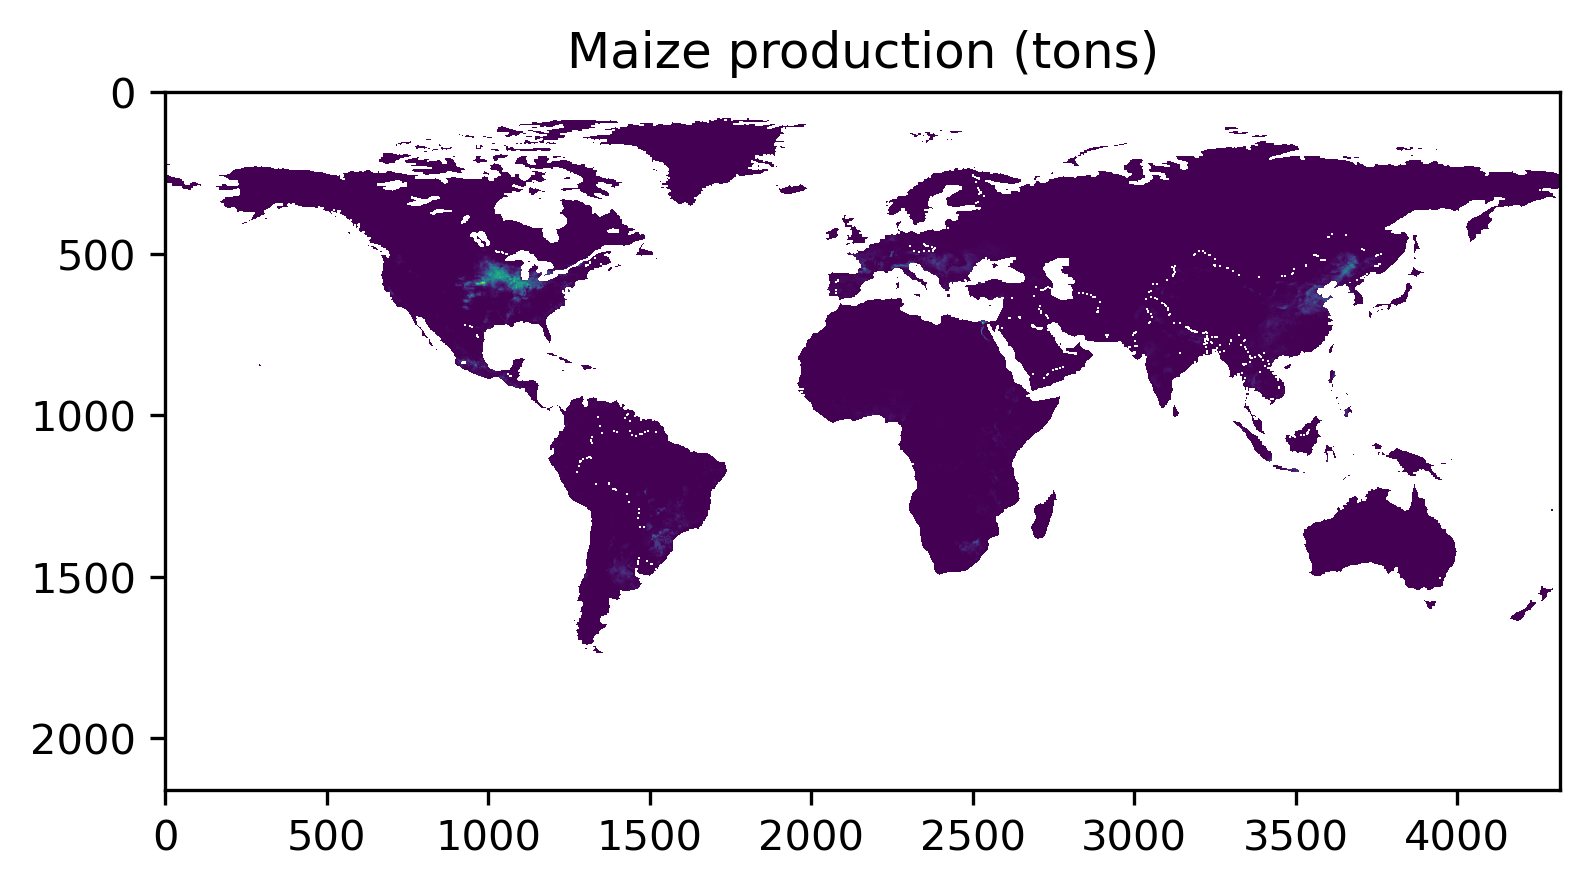

In [24]:

# Multiply them
production_array = harvested_area * yield_per_hectare

# Plot the result using imshow
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.set_title('Maize production (tons)')
fig.set_dpi(300)
im = ax.imshow(production_array)

# Print out how many tons of maize are produced globally
print('Total maize production globally is', np.nansum(production_array), 'tons')

Did we get it right?

![](images/paste-3.png)

# Saving a raster to your harddrive

Now that you've created an amazing raster of total maize production, you might want to save it to your harddrive. We will do this below. First, however, we will talk about geotransforms and projections.

# Projections

Projections are necessary to convert 3d, spherical data about the earth into 2d matrices. If we want an image like below, we need to project the data onto a 2d plane.

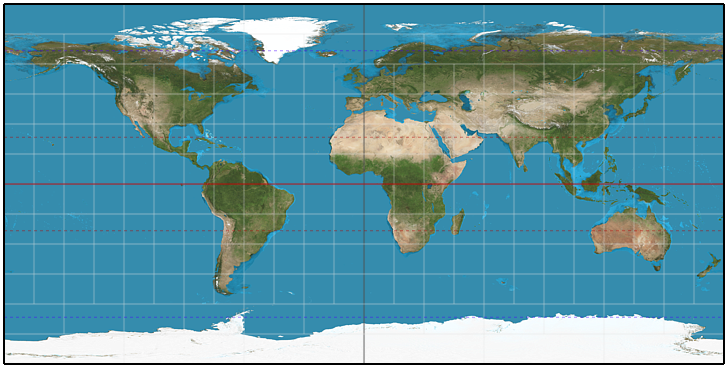

But there are many possible ways of doing that.

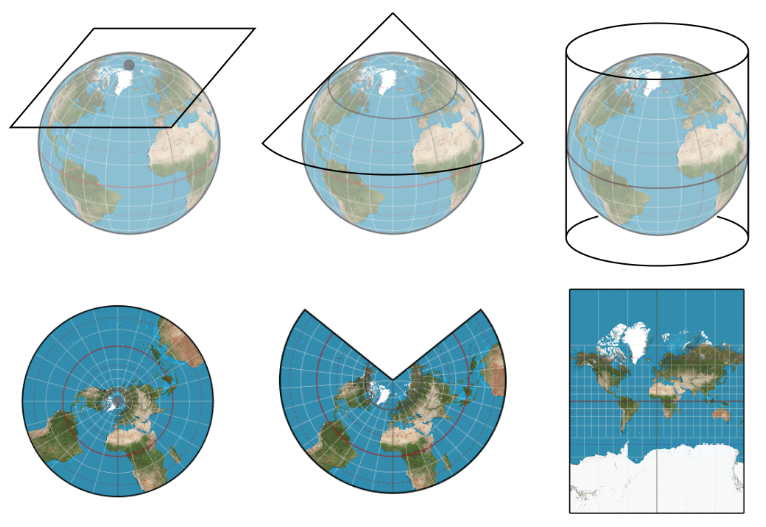

In Python, we summarize all of this complexity into a single object called a projection. A projection is a set of parameters that describe how to convert from 3d to 2d. Let's use GDAL to look at the projection of our data.

In [25]:
# The projection information is stored on the raster Dataset object, so we need to load that on its own
harvested_area_dataset = gdal.Open(harvested_area_file_path)

# Get the projection information
projection = harvested_area_dataset.GetProjection()

print(projection)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


Looking at the projection object above is overwhelming! But fortunately, this is not a GIS course, so we're not going to dive into this other than to appreciate the thousands of geographers who were sacrificed to bring us this information.

Instead, we are just going to **use** that projection variable we just loaded.

### Geotransforms

The other object we need to know about is the geotransform. This says where on the projected coordinate system our raster is located. Let's use python to look at it.

In [26]:
# Load the geotransform
geotransform = harvested_area_dataset.GetGeoTransform()
print(geotransform)

(-180.0, 0.0833333333333286, 0.0, 89.99999999998977, 0.0, -0.0833333333333286)


- You could probably interpret parts of this knowing that there are 180 degrees in half a circle, but let's do it the better way. Instead, a quick google finds the following: 
  
A geotransform consists in a set of 6 coefficients:

- GT(0) x-coordinate of the upper-left corner of the upper-left pixel.

- GT(1) w-e pixel resolution / pixel width.

- GT(2) row rotation (typically zero).

- GT(3) y-coordinate of the upper-left corner of the upper-left pixel.

- GT(4) column rotation (typically zero).

- GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).

Thus we can see in our geotransform above that the upper left corner of our raster is at -180 degrees longitude and 90 degrees latitude. The resolution of our raster is 0.00833333 degrees in both directions. And our raster is oriented with north up (default 0). If we had looked at the geotransform of Rwanda, it would have pointed to a different location on the earth.

Just like with the projection, we are going to use this to save our new raster. But before we do that, we need a little more information about the size of the raster and what the datatype is.

Create a new file at that filename location using the attributes we used above. Notice that we flipped n_cols and n_rows from how numpy would have wanted it. Note that this is an **empty** raster. We haven't written anything to it yet, but we have defined the size and shape of it.

In [27]:
# Get the rows and the columns
n_rows = harvested_area_dataset.RasterYSize
n_cols = harvested_area_dataset.RasterXSize

# The data_type, however, is stored on the band (not the dataset), so we need to load that separately
band_number = 1
harvested_area_band = harvested_area_dataset.GetRasterBand(band_number)
data_type = harvested_area_band.DataType


### Writing the array to a geotiff raster

We are now ready to write our array using the information above. First we are going to create an empty raster at a new location on our harddrive.

In [28]:
# Set the location you want to save at
output_file_path = os.path.join(data_directory, 'maize_production.tif')

# Create a brand new dataset at that location on your harddrive using the information above
output_dataset = gdal.GetDriverByName('GTiff').Create(output_file_path, n_cols, n_rows, band_number, data_type)

- Note that this dataset is EMPTY! It is just point to the location. 
- But we can use the dataset object to do the write.


In [29]:
# First set the output geotransform and projection
output_dataset.SetGeoTransform(geotransform)
output_dataset.SetProjection(projection)

# Then get a new band to write on
output_band = output_dataset.GetRasterBand(band_number)

Do the array writing

In [30]:
output_band.WriteArray(production_array)

0

Set any final band-level information

In [31]:
# output_band.SetNoDataValue(no_data_value)

Finally, and very importantly, clean up after yourself. It wont actually write until the resources in memory have been released.

In [32]:
production_array = None
output_band = None
output_dataset = None

### Look at the new raster in QGIS

If you're like me, you'll probably have forgotten where you saved it. Let's print the path we wrote to so we can find it in our file explorer.

In [33]:
print('HEY! YOU!!!! You wrote a raster HERE: ', output_file_path)

HEY! YOU!!!! You wrote a raster HERE:  ../../../../data\maize_production.tif


Or if you're really lazy like me, print out the absolute path of the directory so we can copy-paste it into our file explorer so I can drag-drop into QGIS.

In [34]:
# Get the directory of the output_file_path
output_directory = os.path.dirname(output_file_path)

print('COPY THIS: ', os.path.abspath(output_directory))

COPY THIS:  c:\Users\jajohns\Files\Teaching\apec_8222\data


We did it!

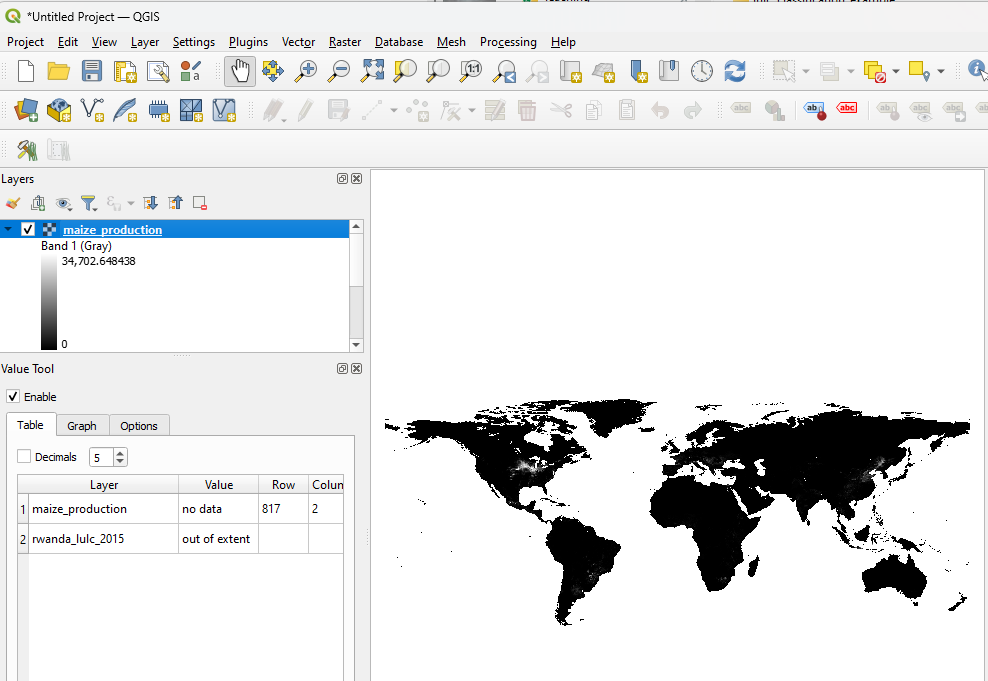

# Real-world example: calculating the potential yield of maize on land that is currently forests in Rwanda

Now that we know how to open, manipulate, and save rasters, we can do some real-world analysis. We're going to calculate the potential yield of maize on land that is currently forests in Rwanda. This might be relevant to, for instance, a regression you would do on household data and whether individuals are likely to cut down their forests to plant maize. Or maybe it would be relevant to your regression on GDP per country if you wanted to know the expected GDP resulting from an increase in agricultural land.

- But let's look at these two files in QGIS. The easiest way to load them into QGIS, in my opinion, is to drag the raster file from your file explorer onto QGIS.

- What we see is not super pretty because we need to modify the colorbar.

![](images/paste-4.png)

## Double-click the layer you added to bring up its properties. Then select the Symbology tab on the left.

![](images/paste-8.png)

## Choose a colorbar you like. Ensure the min-max values are set.

![](images/paste-9.png)

## This looks a little better

![](images/paste-10.png)

## Now add the Rwanda LULC map you loaded earlier

-   It will now show up in the Layers menu

    -   Note that only the topmost checked layer will be displayed on top, covering other things.

    -   Scroll to Rwanda

![](images/paste-12.png)

## We have several visualization problems

-   First, there are very low maize yields in the area, and so they're almost the lightest color.

    -   Adjust the maximium of the colorbar to \~1000 so you can see the variation

-   Second, these two rasters are at very different resolutions!

![](images/paste-14.png)

Any raster-math we do on them will either fail or (worse) succeed at producing nonsense. This is because the underlying numpy arrays are not representing the same part of earth at the same resolution. We will need to do two things first: **clip** and **reproject** one of the layers to match the other.

## Clip

-   In QGIS, Find the command Clip Raster by Extent.

![](images/paste-16.png)

-   This will bring up a Window to launch the tool.

-   Set the Input layer as the Maize layer (this is the one we will clip to be smaller)

-   Set the Clipping Extent to match the Rwanda LULC map.

![](images/paste-17.png)

## The Clipped map doesn't cover all of the LULC!

-   If you thought data cleaning was hard on tabular data...

![](images/paste-21.png)

-   There are tons of ways to fix this in QGIS, but we're actually going to go back to Python to harness the power of a fun new library: Pygeoprocessing.

## Reprojection

-   No matter what way we solve the clipping issue, we also will have to reproject our data to have the same size grid-cells. 
    -   This is necessary to do raster math.

![](images/paste-15.png)

- This brings up the Warp (Reproject) window. This will work, but I want to teach you a better way.

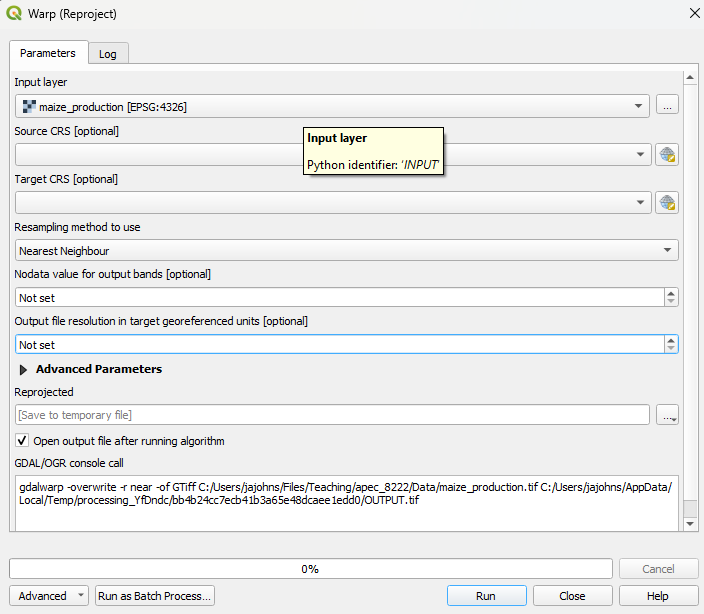

## Pygeoprocessing

-   Pygeoprocessing is a python library that is built on top of GDAL. It is a little more user-friendly and has some nice features.
-   We are going to use the align_and_resize_raster_stack() function.
    -   But, how do we know what to input into this function?
        -   Let's inspect it.
        -   Put your cursor on `align_and_resize_raster_stack` in the code block below and press F-12. Your computer might not access the Function keys automatically (instead overwriting it with some media player nonsense or the like), so you might have to find the Fn button to hold at the same time (this is switchable).
    -   Alternatively, you can right-click on the function and select "Go to Definition".

In [35]:
import pygeoprocessing 

pygeoprocessing.align_and_resize_raster_stack

<function pygeoprocessing.geoprocessing.align_and_resize_raster_stack(base_raster_path_list, target_raster_path_list, resample_method_list, target_pixel_size, bounding_box_mode, base_vector_path_list=None, raster_align_index=None, base_projection_wkt_list=None, target_projection_wkt=None, vector_mask_options=None, gdal_warp_options=None, raster_driver_creation_tuple=('GTIFF', ('TILED=YES', 'BIGTIFF=YES', 'COMPRESS=LZW', 'BLOCKXSIZE=256', 'BLOCKYSIZE=256')), osr_axis_mapping_strategy=0)>

This will bring you straight to the function that you installed via Mamba! It will have extensive documentation.

![](images/paste-22.png)

In [36]:
# Redefine these, just to be safe
lulc_filename = 'rwanda_lulc_2015.tif'
yield_file_path = os.path.join(data_directory, yield_filename)
lulc_file_path = os.path.join(data_directory, lulc_filename)

# Define some new paths to store the aligned and clipped files
yield_aligned_file_path = os.path.join(data_directory, 'yield_aligned.tif')
lulc_aligned_file_path = os.path.join(data_directory, 'lulc_aligned.tif')

print('We are going to save files at ', os.path.abspath(yield_aligned_file_path), ' and ', os.path.abspath(lulc_aligned_file_path))


We are going to save files at  c:\Users\jajohns\Files\Teaching\apec_8222\data\yield_aligned.tif  and  c:\Users\jajohns\Files\Teaching\apec_8222\data\lulc_aligned.tif


### Pygeoprocessing works on lists of many rasters

- Below we will create lists 2-elements long, but this could be arbitrarily longer.

In [37]:

# Configure the paths into lists (this helps the function generalize to MANY files)
base_raster_path_list = [yield_file_path, lulc_file_path]
target_raster_path_list = [yield_aligned_file_path, lulc_aligned_file_path]

# Create a list as long as the above with the resampling for each respective layer. There's Much more to discuss here
# but for now we'll just use bilinear
resample_method_list = ['bilinear', 'bilinear']


### Decide what "spatial set" operation you want to use

-   We are going to use the "intersection" operation. This will ensure that the output raster is only the part of the raster that is in the intersection of the two input rasters.

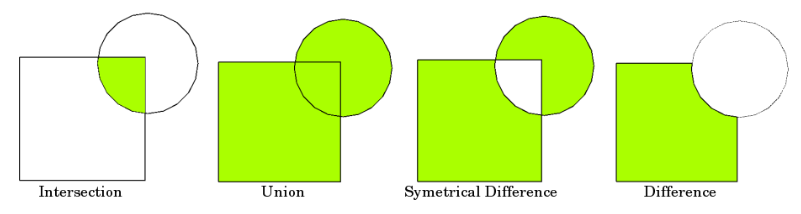

In [38]:

# Next decide which area all the layers will be clipped to. Intersection means it will just be the ones that overlap.
bounding_box_mode = 'intersection'

### Choose which input you want everything aligned to

- We are going to align everything to the Rwanda LULC map
- We are also going to use this to define the pixelsize.

In [39]:


# Decide which of the base_rasters should define the resolution and projection 
# of the output data. For us, we want it to be the resolution of the LULC map, which is 
# in the second position of the list (index 1)
raster_align_index = 1

# Get the pixelsize at this_path. Notice that I'm always REUSING information defined above rather
# than rewriting it.
target_pixel_size = pygeoprocessing.get_raster_info(base_raster_path_list[raster_align_index])['pixel_size']


### We're finally ready to run our function

In [40]:

pygeoprocessing.align_and_resize_raster_stack(base_raster_path_list, 
                                              target_raster_path_list, 
                                              resample_method_list,
                                              target_pixel_size, 
                                              bounding_box_mode, 
                                              raster_align_index=raster_align_index)

## When this first worked for me, I almost cried

Seriously. 

We'll learn more about this package soon.

The key element now is that each of the aligned files has exactly the same resolution and extent, which lets us do raster math on them super easily because for any for any range of row-columns, the values are representing the same place on earth.

But for now, let's load them up in QGIS.

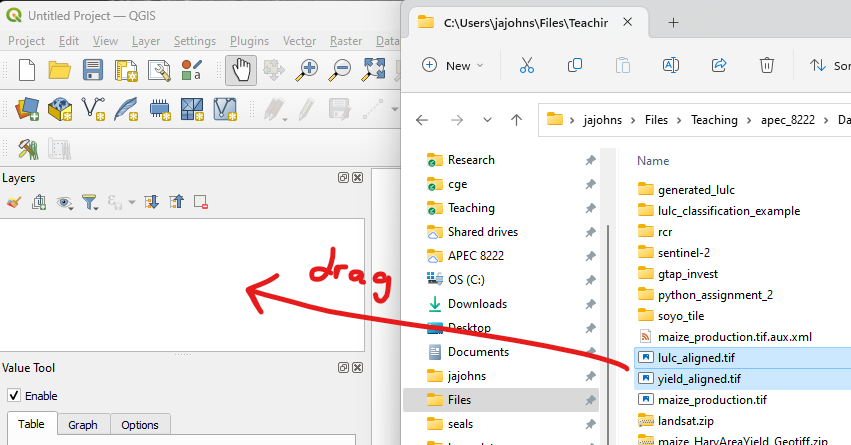

### View them in QGIS

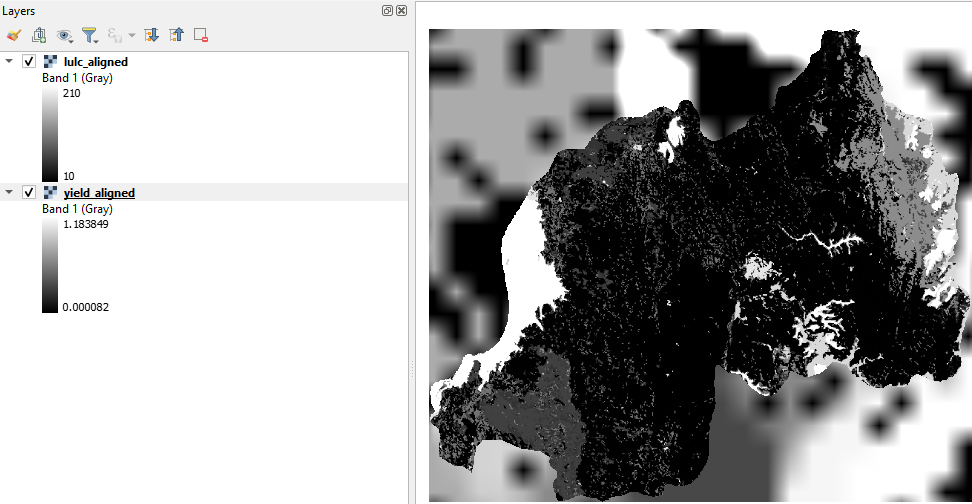
